In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.transforms import Affine2D
import numpy as np
import math
from matplotlib.patheffects import RendererBase
import matplotlib.patheffects as PathEffects
import seaborn as sns

In [148]:
def Rotate(v, theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]]) @ np.array(v).T

def DrawPolygon(x, y, radius, n_edge, color, ax):
    """
    Draw a shape with n_edges centered at x,y, with raidus (center to corner)
    """
    points = []
    for j in range(n_edge):
        cx = 0
        cy = radius
        cx, cy = Rotate([cx, cy], (j-0.5) * 2*math.pi/n_edge)
        points.append([cx+x, cy+y])
    ax.add_patch(patches.Polygon(points, facecolor=color, edgecolor="white"))
    return ax

def HoneycombPlot(data, group, hue = None, default_color = 'blue', 
                  n_edge=6, radius=1, ax=None):
        """
        Draw the honeycomb plot 
        
        Args:
        -----
        data: panda dataframe holding the row data
        group: the column name in data that 
        hue: color of the dot based on the column in the dataframe. Use default color if it is not specified in this dictionary
        n_edge: number of edge for each cluster's shape, default 6 is a heagonal shape
        radius: dot size
        ax: axes objective
        
        Return:
        -----
        axes object
        """
        
        ax = ax or plt.gca()
        
        groupby = data.groupby(group)
        cluster_num = len(groupby)
        
        i = 0
        #if (hue != None):
        #    hue_categories = 
        for g, subdf in sorted(df.groupby("CDR3"), key=lambda item: len(item[1]), reverse=True):
            count = len(subdf)
            centerx = i
            centery = 0 
            x = []
            y = []
            
            lap = 0
            lap_full = 1
            for j in range(count):
                tmpx = 0
                tmpy = lap * 0.25
                
                tmpx, tmpy = Rotate([tmpx, tmpy], (j - 0.5) * 2*math.pi/n_edge)
                x.append(tmpx + centerx)
                y.append(tmpy + centery)
                
                if (j == lap_full):
                    lap += 1
                    lap_full += n_edge 
            for xi, yi in zip(x, y):
                DrawPolygon(xi, yi, 0.1, n_edge, default_color, ax)
            i += 1
        return ax
        

In [16]:
df = pd.DataFrame({"CDR3":["ABC", "ABC", "ABC", "ABC",
                          "ABC", "ABC", "ABC", "ABC",
                          "ABC", "DEF", "DEF", "GHI"],
                  "Condition":["HD", "HD", "HD", "HD",
                              "D", "D", "HD", "D",
                              "HD", "HD", "D", "D"]})

[(-1.0, 3.0), (-1.0, 3.0)]

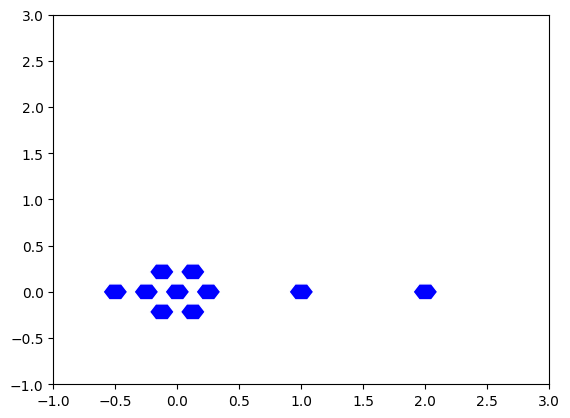

In [151]:
ax=HoneycombPlot(df, "CDR3", n_edge=6, radius=10)
ax.set(xlim=(-1,3), ylim=(-1,3))

In [22]:
for x, subdf in sorted(df.groupby("CDR3"), key=lambda item: len(item[1]), reverse=True):
    print(x)
    print(subdf)

ABC
  CDR3 Condition
0  ABC        HD
1  ABC        HD
2  ABC        HD
3  ABC        HD
4  ABC         D
5  ABC         D
6  ABC        HD
7  ABC         D
8  ABC        HD
DEF
   CDR3 Condition
9   DEF        HD
10  DEF         D
GHI
   CDR3 Condition
11  GHI         D
